# INF473V - 2021 - TD7: Object detection, Part 2
## Vicky Kalogeiton

# 1a. Download useful functions 
For the excercises here you need to donwload the [`utils.py`](http://vicky.kalogeiton.info/assets/utils.py) function and import it directly.

# 1b. Save `.py` 

* **Part 1: `boxutils.py`**: You need to save all functions we created in Part 1 in a file called `boxutils.py`. 

You need to have these files in the current folder. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
path_to_my_drive = "/content/drive/MyDrive"
os.chdir(path_to_my_drive)
#from utils import *
from boxutils import *
# print(os.listdir())


ModuleNotFoundError: ignored

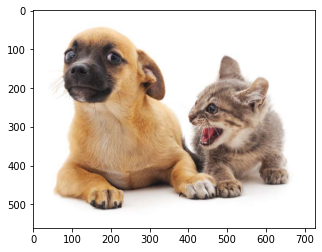

The height and width of the image are (561, 728)
The shape of the multiboxes we generated is (1, 2042040, 4),
with batch_size=1, number of anchor boxes =2042040, coordinates= 4
Note that w x h x (s+r-1) = 728 x 561 x (3+3-1) = 2042040 anchors


NameError: ignored

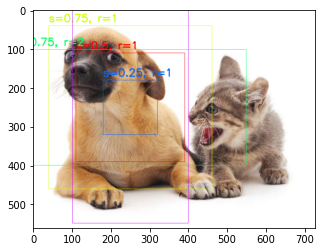

In [ ]:
import boxutils

In [ ]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/")


In [ ]:
sys.path

['/content/drive/MyDrive/',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

# 2. Single-Shot Detector (SSD)

The SSD is a purely convolutional neural network (CNN) that we can organize into three parts:
* **A. Base convolutions** derived from an existing image classification architecture that will provide lower-level feature maps.
* **B. Auxiliary convolutions** added on top of the base network that will provide higher-level feature maps.
* **D. Prediction convolutions** that will locate and identify objects in these feature maps.
* Another important part of the network is **C. Anchors**. 

The paper demonstrates two variants of the model called the SSD300 and the SSD512. The suffixes represent the size of the input image. Although the two networks differ slightly in the way they are constructed, they are in principle the same. The SSD512 is just a larger network and results in marginally better performance.

For convenience, we will deal with the SSD300.

<!--![](https://drive.google.com/uc?export=view&id=1dNuNzTbdiuif-9ECaKH7qBSrLMdo2IyK)-->
<img src="https://drive.google.com/uc?export=view&id=1dNuNzTbdiuif-9ECaKH7qBSrLMdo2IyK" alt="drawing" width="800"/>

## A. Base Convolutions – part 1
First, why use convolutions from an existing network architecture?

Because models proven to work well with image classification are already pretty good at capturing the basic essence of an image. The same convolutional features are useful for object detection, albeit in a more local sense – we're less interested in the image as a whole than specific regions of it where objects are present.

There's also the added advantage of being able to use layers pretrained on a reliable classification dataset. As you may recall, this is called Transfer Learning. By borrowing knowledge from a different but closely related task, we've made progress before we've even begun.

SSD employs the VGG-16 architecture as the base network (pretrained on the ImageNet classification task). 

To implement SSD, we have to make some changes to this pretrained network to adapt it to our own challenge of object detection. Some are logical and necessary, while others are mostly a matter of convenience or preference: 
* The input image size will be $300, 300$.
* The 3rd pooling layer, which halves dimensions, will use the mathematical ceiling function instead of the default floor function in determining output size. This is significant only if the dimensions of the preceding feature map are odd and not even. By looking at the image above, you could calculate that for our input image size of 300, 300, the conv3_3 feature map will be of cross-section 75, 75, which is halved to 38, 38 instead of an inconvenient 37, 37.
* We modify the 5th pooling layer from a 2, 2 kernel and 2 stride to a 3, 3 kernel and 1 stride. The effect this has is it no longer halves the dimensions of the feature map from the preceding convolutional layer.
* We don't need the fully connected (i.e. classification) layers because they serve no purpose here. We will toss fc8 away completely, but choose to rework fc6 and fc7 into convolutional layers conv6 and conv7.

The first three modifications are straightforward enough, but that last one probably needs some explaining.

### FC → Convolutional Layer
How do we reparameterize a fully connected layer into a convolutional layer?

Consider the following scenario.

In the typical image classification setting, the first fully connected layer cannot operate on the preceding feature map or image directly. We'd need to flatten it into a 1D structure.

<img src="https://drive.google.com/uc?export=view&id=1nOnWL-5Dm8DZUJSN7mlt-_DWI0BUlZDk" alt="drawing" width="700"/>
<!--
![](https://drive.google.com/uc?export=view&id=1nOnWL-5Dm8DZUJSN7mlt-_DWI0BUlZDk)
-->


In this example, there's an image of dimensions $2, 2, 3$, flattened to a 1D vector of size 12. For an output of size $2$, the fully connected layer computes two dot-products of this flattened image with two vectors of the same size $12$. These two vectors, shown in gray, are the parameters of the fully connected layer.

Now, consider a different scenario where we use a convolutional layer to produce $2$ output values.

<img src="https://drive.google.com/uc?export=view&id=14z78KAhxLU1maCEvIFGsaCeu6Ych-5R6" alt="drawing" width="500"/>
<!--
![](https://drive.google.com/uc?export=view&id=14z78KAhxLU1maCEvIFGsaCeu6Ych-5R6)
-->

Here, the image of dimensions $2, 2, 3$ need not be flattened, obviously. The convolutional layer uses two filters with $12$ elements in the same shape as the image to perform two dot products. These two filters, shown in gray, are the parameters of the convolutional layer.

But here's the key part – in both scenarios, the outputs $Y_0$ and $Y_1$ are the same!

<img src="https://drive.google.com/uc?export=view&id=1MpGWg4-XuZq4K1_wWXVPnPap2urPCVY-" alt="drawing" width="500"/>
<!--
![](https://drive.google.com/uc?export=view&id=1MpGWg4-XuZq4K1_wWXVPnPap2urPCVY-)
-->

The two scenarios are equivalent.

What does this tell us?

That on an image of size $H, W$ with $I$ input channels, a fully connected layer of output size $N$ is equivalent to a convolutional layer with kernel size equal to the image size $H, W$ and $N$ output channels, provided that the parameters of the fully connected network $N, H * W * I$ are the same as the parameters of the convolutional layer $N, H, W, I$.


<img src="https://drive.google.com/uc?export=view&id=1vWzz0eCQMw0u19gBJ1aJbmVFzuaafa-m" alt="drawing" width="500"/>
<!--
![](https://drive.google.com/uc?export=view&id=1vWzz0eCQMw0u19gBJ1aJbmVFzuaafa-m)
-->

Therefore, any fully connected layer can be converted to an equivalent convolutional layer simply by reshaping its parameters.

## A. Base Convolutions – part 2

We now know how to convert $fc6$ and $fc7$ in the original VGG-16 architecture into $conv6$ and $conv7$ respectively.

In the ImageNet VGG-16, which operates on images of size $224, 224, 3$, the output of $conv5_3$ is of size $7, 7, 512$. Therefore: 
* $fc6$ with a flattened input size of $7 * 7 * 512$ and an output size of $4096$ has parameters of dimensions $4096, 7 * 7 * 512$. The equivalent convolutional layer $conv6$ has a $7, 7$ kernel size and $4096$ output channels, with reshaped parameters of dimensions $4096, 7, 7, 512$.
* $fc7$ with an input size of $4096$ (i.e., the output size of $fc6$) and an output size $4096$ has parameters of dimensions $4096, 4096$. The input could be considered as a $1, 1$ image with $4096$ input channels. The equivalent convolutional layer $conv7$ has a $1, 1$ kernel size and $4096$ output channels, with reshaped parameters of dimensions $4096, 1, 1, 4096$.

$conv6$ has $4096$ filters, each with dimensions $7, 7, 512$, and $conv7$ has $4096$ filters, each with dimensions $1, 1, 4096$.

These filters are numerous and large – and computationally expensive.
To remedy this, we will reduce both their number and the size of each filter by subsampling parameters from the converted convolutional layers:
* $conv6$ will use $1024$ filters, each with dimensions $3, 3, 512$. Therefore, the parameters are subsampled from $4096, 7, 7, 512$ to $1024, 3, 3, 512$.
* $conv7$ will use $1024$ filters, each with dimensions $1, 1, 1024$. Therefore, the parameters are subsampled from $4096, 1, 1, 4096$ to $1024, 1, 1, 1024$.

We will subsample by picking every $m$-th parameter along a particular dimension, in a process known as *decimation*.

Since the kernel of $conv6$ is decimated from $7, 7$ to $3, 3$ by keeping only every 3rd value, there are now holes in the kernel. Therefore, we would need to make the **kernel dilated or atrous**.

This corresponds to a dilation of $3$ (same as the decimation factor $m = 3$). However, the authors actually use a dilation of $6$, possibly because the 5th pooling layer no longer halves the dimensions of the preceding feature map.

The base network, i.e., the modified VGG-16, is shown below:
<img src="https://drive.google.com/uc?export=view&id=1mfvGHE6QyaFKdJmuh9157XzD_QFlAWH2" alt="drawing" width="700"/>
<!--
![](https://drive.google.com/uc?export=view&id=1mfvGHE6QyaFKdJmuh9157XzD_QFlAWH2)
-->
# Question 6 
Fill in the implementation below

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from math import sqrt
from itertools import product as product
import torchvision
#from utils import * 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VGGBase(nn.Module):
    """
    VGG base convolutions to produce lower-level feature maps.
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        # TODO-a
        self.conv6 = nn.Conv2d(512 ,1024,kernel_size = 3, dilation =6, padding = 6)
        self.conv7 = nn.Conv2d(1024 ,1024,kernel_size =1)
        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward propagation.
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        # TODO-b
        # conv7_feats = ...
        out = F.relu(self.conv6(out))
        out = F.relu(self.conv7(out))
        conv7_feats = out
        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        As in the paper, we use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        We copy these parameters into our network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation. 
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)

        print("\nLoaded base model.\n")

## B. Auxeliary Convolutions 

We will now stack some more convolutional layers on top of our base network. These convolutions provide additional feature maps, each progressively smaller than the last.

<!--![](https://drive.google.com/uc?export=view&id=1kzvntHbNckXjVHctS2wFHG5uZjLCHAzP)-->
<img src="https://drive.google.com/uc?export=view&id=1kzvntHbNckXjVHctS2wFHG5uZjLCHAzP" alt="drawing" width="800"/>

* We introduce four convolutional blocks, each with two layers. 
* While size reduction happened through pooling in the base network, here it is facilitated by a stride of $2$ in every second layer.

Again, take note of the feature maps from $conv8_2, conv9_2, conv10_2$, and $conv11_2$.

# Question 7

Fill in the implementation of auxeliary convolutions below. 

In [2]:
class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        # Auxiliary/additional convolutions on top of the VGG base
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)  # stride = 1, by default
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        # TODO - a
        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride =2)

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):
        """
        Forward propagation.
        :param conv7_feats: lower-level conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        # TODO - b
        out = F.relu(self.conv9_1(out))
        out = F.relu(self.conv9_2(out))
        conv9_2_feats = out

        out = F.relu(self.conv10_1(out))
        out = F.relu(self.conv10_2(out))
        conv10_2_feats = out

        out = F.relu(self.conv11_1(out))
        out = F.relu(self.conv11_2(out))
        conv11_2_feats = out
        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats


## C. Anchors (or Priors or Default boxes)

Object predictions can be quite diverse, as they can occur at any position, with any size and shape. As discussed before, 
anchors are precalculated, fixed boxes which collectively represent *all probable and approximate box predictions*.

Anchors are manually but carefully chosen based on the shapes and sizes of ground truth objects in a dataset. By placing them at every possible location in a feature map, we also account for variety in position.

In SSD: 
* the anchors are applied to various low-level and high-level feature maps:  those from $conv4_3, conv7, conv8_2, conv9_2, conv10_2$, and $conv11_2$. These are the same feature maps indicated on the figures before. 
* if an anchor has a scale $s$, then its area is equal to that of a square with side $s$. The largest feature map, $conv4_3$, has anchors with a scale of $0.1$, i.e. 10% of image's dimensions, while the rest have anchors with scales linearly increasing from $0.2$ to $0.9$. **Larger feature maps** have anchors with smaller scales and are therefore ideal for detecting **smaller objects**.
* At each position on a feature map, there are anchors of various aspect ratios. All feature maps have anchors with ratios $1:1, 2:1, 1:2$. The intermediate feature maps of $conv7, conv8_2, and conv9_2$  also have anchors with ratios $3:1, 1:3$. Moreover, all feature maps have one extra anchor with an aspect ratio of $1:1$ and at a scale that is the geometric mean of the scales of the current and subsequent feature map.

The Table below summarizes this: 

| Feature Map From | Feature Map Dimensions | Anchor Scale | Aspect Ratios | Number of Anchors per Position | Total Number of Anchors on this Feature Map |
| :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: |
| `conv4_3`      | 38, 38       | 0.1 | 1:1, 2:1, 1:2 + an extra anchor | 4 | 5776 |
| `conv7`      | 19, 19       | 0.2 | 1:1, 2:1, 1:2, 3:1, 1:3 + an extra anchor | 6 | 2166 |
| `conv8_2`      | 10, 10       | 0.375 | 1:1, 2:1, 1:2, 3:1, 1:3 + an extra anchor | 6 | 600 |
| `conv9_2`      | 5, 5       | 0.55 | 1:1, 2:1, 1:2, 3:1, 1:3 + an extra anchor | 6 | 150 |
| `conv10_2`      | 3,  3       | 0.725 | 1:1, 2:1, 1:2 + an extra anchor | 4 | 36 |
| `conv11_2`      | 1, 1       | 0.9 | 1:1, 2:1, 1:2 + an extra anchor | 4 | 4 |
| **Grand Total**      |    –    | – | – | – | **8732 anchors** |

There are a total of 8732 anchors defined for the SSD300!

### Visualizing Anchors

We defined anchors in terms of their _scales_ and _aspect ratios_: $w \cdot h = s^2$ and $\frac{w}{h}=a$.  Solving these equations yields the dimensions `w` and `h` of the anchor: $w=s \cdot \sqrt{a}$, and $h=\frac{s}{\sqrt{a}}$. 
Now, we can draw them on their respective feature maps. 

For example, let's try to visualize what the anchors will look like at the central tile of the feature map from `conv9_2`.

<img src="https://drive.google.com/uc?export=view&id=1AsD7MwczI_WFAHujIJJP85eRyUkki4d6" alt="drawing" width="600"/>
<!--
![priors1](https://drive.google.com/uc?export=view&id=1AsD7MwczI_WFAHujIJJP85eRyUkki4d6)
-->

The same anchors also exist for each of the other tiles.

<img src="https://drive.google.com/uc?export=view&id=1Vdh31F3obbsS036MihApc_88samxMV0i" alt="drawing" width="600"/>
<!--
![priors2](https://drive.google.com/uc?export=view&id=1Vdh31F3obbsS036MihApc_88samxMV0i) -->

### Offsets 

As discussed before, we use anchors as an approximate starting point for the predicted bounding boxes and then find out how much they need to be adjusted to obtain a more exact prediction for each bounding box.

Recall: Assume the center coordinates of anchor box $A$ and its assigned ground-truth bounding box $B$ are $(x_a, y_a), (x_b, y_b)$, the widths of $A$ and $B$ are $w_a, w_b$, and their heights are $h_a, h_b$, respectively. The offsets of $A$ are: 

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$

The default values of the constant are $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$, and $\sigma_w=\sigma_h=0.2$. 

Each anchor is adjusted to obtain a more precise prediction, **these four offsets `(g_c_x, g_c_y, g_w, g_h)` are the form in which we will regress bounding boxes' coordinates**.

As you can see, each offset is normalized by the corresponding dimension of the anchor. This makes sense because a certain offset would be less significant for a larger anchor than it would be for a smaller anchor.

## D. Prediction convolutions

We defined anchors for six feature maps of various scales and granularity, i.e., those from `conv4_3`, `conv7`, `conv8_2`, `conv9_2`, `conv10_2`, and `conv11_2`.

Then, **for _each_ anchor at _each_ location on _each_ feature map**, we want to predict:

- the **offsets `(g_c_x, g_c_y, g_w, g_h)`** for a bounding box.
- a set of **`n_classes` scores** for the bounding box, where `n_classes` represents the total number of object types (including a _background_ class).

To do this in the simplest manner possible, **we need two convolutional layers for each feature map**:

- a **_localization_ prediction** convolutional layer with a `3,  3` kernel evaluating at each location (i.e. with padding and stride of `1`) with `4` filters for _each_ anchor present at the location.

  The `4` filters for a anchor calculate the four encoded offsets `(g_c_x, g_c_y, g_w, g_h)` for the bounding box predicted from that anchor.

- a **_class_ prediction** convolutional layer with a `3,  3` kernel evaluating at each location (i.e. with padding and stride of `1`) with `n_classes` filters for _each_ anchor present at the location.

  The `n_classes` filters for a anchor calculate a set of `n_classes` scores for that anchor.

<img src="https://drive.google.com/uc?export=view&id=1vy0XN-1rkZQvM7FGbN210JauCY3kPS13" alt="drawing" width="900"/>
<!--
![predconv1](https://drive.google.com/uc?export=view&id=1vy0XN-1rkZQvM7FGbN210JauCY3kPS13)
-->

All our filters are applied with a kernel size of `3, 3`.

We don't really need kernels (or filters) in the same shapes as the anchors because the different filters will _learn_ to make predictions with respect to the different anchor shapes.

Let's take a look at the **outputs of these convolutions**. Consider again the feature map from `conv9_2`.

<img src="https://drive.google.com/uc?export=view&id=16gXaMAIhnsNfzIExjuMvR92PQYQsL03e" alt="drawing" width="600"/>
<!--
![predconv2](https://drive.google.com/uc?export=view&id=16gXaMAIhnsNfzIExjuMvR92PQYQsL03e)
-->

The outputs of the localization and class prediction layers are shown in blue and yellow respectively. You can see that the cross-section (`5, 5`) remains unchanged.

What we're really interested in is the _third_ dimension, i.e. the channels. These contain the actual predictions.

If you **choose a tile, _any_ tile, in the localization predictions and expand it**, what will you see?

<img src="https://drive.google.com/uc?export=view&id=1U5_BTJZOsCBRGq6km0ArIoWSmM3czZ28" alt="drawing" width="600"/>

<!-- a ![predconv3](https://drive.google.com/uc?export=view&id=1U5_BTJZOsCBRGq6km0ArIoWSmM3czZ28) -->

The channel values at each position of the localization predictions represent the encoded offsets with respect to the anchors at that position.

Now, **do the same with the class predictions.** Assume `n_classes = 3`.

<img src="https://drive.google.com/uc?export=view&id=1BKZL1ghLS5TDZOnFaXHv9C5-4LMJW5hA" alt="drawing" width="600"/>

<!-- ![predconv4](https://drive.google.com/uc?export=view&id=1BKZL1ghLS5TDZOnFaXHv9C5-4LMJW5hA) -->


Similar to before, these channels represent the class scores for the anchors at that position.

Now that we understand what the predictions for the feature map from `conv9_2` look like, we can **reshape them into a more amenable form.**

<img src="https://drive.google.com/uc?export=view&id=1ch8jWjlk8swRH7j5IBDh7Ik30-o3pXA4" alt="drawing" width="600"/>

<!--  ![reshaping1](https://drive.google.com/uc?export=view&id=1ch8jWjlk8swRH7j5IBDh7Ik30-o3pXA4) -->

We have arranged the `150` predictions serially. 

We could do the same for the predictions for _all_ layers and stack them together.

We calculated earlier that there are a total of 8732 anchors defined for our model. Therefore, there will be **8732 predicted boxes in encoded-offset form, and 8732 sets of class scores**.

<img src="https://drive.google.com/uc?export=view&id=1x3rbRcy5RYajgRRdUIBQZWBisn5LkQij" alt="drawing" width="600"/>

<!-- ![reshaping2](https://drive.google.com/uc?export=view&id=1x3rbRcy5RYajgRRdUIBQZWBisn5LkQij) -->


**This is the final output of the prediction stage.** A stack of boxes, if you will, and estimates for what's in them.

# Question 8

Fill in the following implementation


In [4]:
class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.
    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 anchor boxes.
    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self, n_classes):
        """
        :param n_classes: number of different types of objects
        """
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of anchor-boxes we are considering per position in each feature map
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        # 4 anchor-boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t anchor-boxes)
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        
        # TODO - a
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)
        
        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)

        # TODO - b
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)
        
        

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        """
        Forward propagation.
        :param conv4_3_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map, a tensor of dimensions (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map, a tensor of dimensions (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map, a tensor of dimensions (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map, a tensor of dimensions (N, 256, 1, 1)
        :return: 8732 locations and class scores (i.e. w.r.t each anchor box) for each image
        """
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t anchor-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()  # (N, 38, 38, 16), to match anchor-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        # TODO - c
        l_conv7 = self.loc_conv7(conv7_feats)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()
        l_conv7 = l_conv7.view(batch_size, -1, 4)


        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)

  
        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)


        l_conv10_2 = self.loc_conv(conv10_2_feats)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)

        
        l_conv11_2 = self.loc_conv(conv11_2_feats)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        # (N, 38, 38, 4 * n_classes), to match anchor-box order (after .view())
        c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous()  
        # (N, 5776, n_classes), there are a total 5776 boxes on this feature map
        c_conv4_3 = c_conv4_3.view(batch_size, -1,self.n_classes)  

        # TODO - d
        c_conv7 = self.loc_conv7(conv7_feats)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()
        c_conv7 = c_conv7.view(batch_size, -1, 4)


        c_conv8_2 = self.loc_conv8_2(conv8_2_feats)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()
        c_conv8_2 = c_conv8_2.view(batch_size, -1, 4)

  
        c_conv9_2 = self.loc_conv9_2(conv9_2_feats)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()
        c_conv9_2 = c_conv9_2.view(batch_size, -1, 4)


        c_conv10_2 = self.loc_conv(conv10_2_feats)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()
        c_conv10_2 = c_conv10_2.view(batch_size, -1, 4)

        
        c_conv11_2 = self.loc_conv(conv11_2_feats)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()
        c_conv11_2 = c_conv11_2.view(batch_size, -1, 4)

        # A total of 8732 boxes
        # Concatenate in this specific order (i.e. must match the order of the anchor-boxes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],
                                   dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores


## E. Multibox loss

As discussed, the multibox loss will **aggregate the losses from both types of predictions** – bounding box localizations and class scores.

#### Matching predictions to ground truths

For matching the predictions to the ground truth bounding boxes, we follow the procedure described in the previous notebook: 
- **Find the Jaccard (IoU) overlaps** between the 8732 anchors and `N` ground truth objects. This will be a tensor of size `8732, N`.
- **Match** each of the 8732 anchors to the object with which it has the greatest overlap.
- If a anchor is matched with an object with a **Jaccard overlap of less than `0.5`**, then it cannot be said to "contain" the object, and is therefore a **_negative_ match**. Considering we have thousands of anchors, most anchors will test negative for an object.
- On the other hand, a handful of anchors will actually **overlap significantly (greater than `0.5`)** with an object, and can be said to "contain" that object. These are **_positive_ matches**.
- Now that we have **matched each of the 8732 anchors to a ground truth**, we have, in effect, also **matched the corresponding 8732 predictions to a ground truth**.  

After this, **each anchor has a match**, positive or negative. By extension, **each prediction has a match**, positive or negative.

Predictions that are positively matched with an object now have ground truth coordinates that will serve as **targets for localization**, i.e. in the _regression_ task. Naturally, there will be no target coordinates for negative matches.

All predictions have a ground truth label, which is either the type of object if it is a positive match or a _background_ class if it is a negative match. These are used as **targets for class prediction**, i.e. the _classification_ task.

### Localization loss

As experted, we have **no ground truth coordinates for the negative matches**. Therefore, the localization loss is computed only on how accurately we regress positively matched predicted boxes to the corresponding ground truth coordinates.

Since we predicted localization boxes in the form of offsets `(g_c_x, g_c_y, g_w, g_h)`, we would also need to encode the ground truth coordinates accordingly before we calculate the loss.

The localization loss is the averaged **Smooth L1** loss between the encoded offsets of positively matched localization boxes and their ground truths:
$$ l_{loc} = \frac{1}{ n_{positives} } \left( \sum_{positives} SmoothL_{1}Loss \right)$$

#### Confidence loss

Every prediction, no matter positive or negative, has a ground truth label associated with it. It is important that the model recognizes both objects and a lack of them.

However, considering that there are usually only a handful of objects in an image, **the vast majority of the thousands of predictions we made do not actually contain an object**. 

If the negative matches overwhelm the positive ones, we will end up with a model that is less likely to detect objects because, more often than not, it is taught to detect the _background_ class. 
The solution is to limit the number of negative matches that will be evaluated in the loss function. To do this, we will use the ones that the model was most _wrong_ about? In other words, only use those predictions where the model found it hardest to recognize that there are no objects. This is called **Hard Negative Mining**.

The number of hard negatives `N_hn` we use is usually a fixed multiple of the number of positive matches for this image. In the case of SSD, we use three times as many hard negatives, i.e. `N_hn = 3 * N_p`. The hardest negatives are discovered by finding the Cross Entropy loss for each negatively matched prediction and choosing those with top `N_hn` losses.

Then, the confidence loss is simply the sum of the **Cross Entropy** losses among the positive and hard negative matches.

$$L_{conf} = \frac{1}{ n_{positives} } \left( \sum_{positives} CELoss + \sum_{hard-negatives} CELoss \right) $$

You will notice that it is averaged by the number of positive matches.

#### Total loss

The **Multibox loss is the aggregate of the two losses**, combined in a ratio `α`: 
$$ L = L_{conf} + a \cdot L_{loc} $$

In general, we needn't decide on a value for `α`. It could be a learnable parameter. In SSD, however, we use `α = 1`, i.e. add the two losses. 

In [5]:
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.
    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, anchors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.anchors_cxcy = anchors_cxcy
        self.anchors_xy = box_center_to_corner(anchors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 anchor boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_anchors = self.anchors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_anchors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_anchors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_anchors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            ####################################
            ###### TODO: copy function box_iou from Part 1 
            ####################################
            overlap = box_iou(boxes[i], self.anchors_xy)  # (n_objects, 8732)

            # For each anchor, find the object that has the maximum overlap
            overlap_for_each_anchor, object_for_each_anchor = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) anchors -
            # 1. An object might not be the best object for all anchors, and is therefore not in object_for_each_anchor.
            # 2. All anchors with the object may be assigned as background based on the threshold (0.5).

            # So: 
            # First, find the anchor that has the maximum overlap for each object.
            _, anchor_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-anchor. (This fixes 1.)
            object_for_each_anchor[anchor_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these anchors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_anchor[anchor_for_each_object] = 1.

            # Labels for each anchors
            label_for_each_anchor = labels[i][object_for_each_anchor]  # (8732)
            # Set anchors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_anchor[overlap_for_each_anchor < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_anchor

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            ####################################
            ### TODO: copy functions offset_boxes, box_center_to_corner from part 1
            ####################################
            true_locs[i] = offset_boxes(box_center_to_corner(self.anchors_cxcy), boxes[i][object_for_each_anchor])  # (8732, 4)

        # Identify anchors that are positive (object/non-background)
        positive_anchors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) anchors
        loc_loss = self.smooth_l1(predicted_locs[positive_anchors], true_locs[positive_anchors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_anchors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive anchors and the most difficult (hardest) negative anchors in each image
        # FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative anchors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative anchors per image
        n_positives = positive_anchors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all anchors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_anchors)  # (N, 8732)

        # We already know which anchors are positive
        conf_loss_pos = conf_loss_all[positive_anchors]  # (sum(n_positives))

        # Next, find which anchors are hard-negative
        # To do this, sort ONLY negative anchors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_anchors] = 0.  # (N, 8732), positive anchors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_anchors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # Averaged over positive anchors only, although computed over both positive and hard-negative anchors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss

# The whole SSD together: 

In [6]:
class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base VGG network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Anchor boxes
        self.priors_cxcy = self.create_anchor_boxes()

    def forward(self, image):
        """
        Forward propagation.
        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: 8732 locations and class scores (i.e. w.r.t each anchor box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        conv4_3_feats, conv7_feats = self.base(image)  # (N, 512, 38, 38), (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)
        # (PyTorch autobroadcasts singleton dimensions during arithmetic)

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = \
            self.aux_convs(conv7_feats)  # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offsets w.r.t anchor-boxes and classes in each resulting localization box)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats,
                                               conv11_2_feats)  # (N, 8732, 4), (N, 8732, n_classes)

        return locs, classes_scores

    def create_anchor_boxes(self):
        """
        Create the 8732 anchor (default) boxes for the SSD300
        :return: anchor boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        anchor_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        anchor_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional anchor whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            anchor_boxes.append([cx, cy, additional_scale, additional_scale])

        anchor_boxes = torch.FloatTensor(anchor_boxes).to(device)  # (8732, 4)
        anchor_boxes.clamp_(0, 1)  # (8732, 4)

        return anchor_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.
        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 anchor boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_anchors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_anchors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            # (8732, 4), these are fractional pt. coordinates
            ####################################
            ### TODO: copy functions offset_inverse, box_center_to_corner from part 1
            ####################################
            decoded_locs = offset_inverse(box_center_to_corner(self.priors_cxcy), predicted_locs[i])  
            

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                ####################################
                ###### TODO: copy function box_iou from Part 1 
                ####################################
                overlap = box_iou(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)
                # For simplicity, we do not use the nms function from Part 1, as we would need to modify it to also return 
                # the class score and then find the class label of the kept boxes. 
                # keep_boxes = nms(boxes, scores, iou_threshold=max_overlap)
                
                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size
